# Plot dvv time histories
2023.04.24 Kurama Okubo

This notebook plot dv/v time histories with various cases.

**NOTE:** Please first run the `plotfigure_convert_dvvdata.ipynb` to save the csv file in pandas multicolumns format.

Plot list:

1. all dvv
2. different components
3. different frequency band
4. comparison with channel weight

- 2023.04.25 update plotting with ppsd. We decided to use the number of correlation pairs instead of probabilistic power spectrum density because it is unfair to compare the distributions between time windows with different total number of station pairs after thresholding out, which causes a bias to degrade the variance of the velocity measurements.

- 2023.05.02 add compact figure for the number of pairs
- 2023.06.27 update the CC threshold from 0.8 to 0.7
- 2023.07.13 add holizontal line at dvv=0; compute the slope for different frequency bands
- 2023.10.06 update notation of $b_0$

In [1]:
import datetime
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy import stats

%matplotlib inline
import seaborn as sns 
# import importParaviewColormap
import numpy as np
import pandas as pd
import h5py

import shutil
from tqdm import tqdm

import matplotlib as mpl

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

In [2]:
root_csv = "../plotcsv_masterdata"
csv_stats_list = [root_csv + "/dvvdata_all_stretching.csv",
                              root_csv + "/dvvdata_all_mwcs.csv"]

In [3]:
#---set the file path of your case study list---#
csv_stats_id = 1 # 0: stretching 1:mwcs

starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2022, 6, 1)

cc_time_unit=86400 # short-stacking time unit
averagestack_factor=30 # length of time bin to compute mean and std
averagestack_step=15

cc_threshold = 0.7 #0.8 # threshold of correlation coefficient
err_mwcs_eps= 2e-4 #0.5-0.9: 0.005  #[%]

output_datadir = "../plotcsv_masterdata"
output_imgdir = "../figure/plotdvv_master"

image_format="png"
dpi = 150
show=True
#-------------------------------------------#

if not os.path.exists(output_datadir):
    os.makedirs(output_datadir)

if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)

# Plot all dvv

In [4]:
df_stretching = pd.read_csv(csv_stats_list[0], header=[0, 1, 2, 3], index_col=0)
df_mwcs = pd.read_csv(csv_stats_list[1], header=[0, 1, 2, 3], index_col=0)

In [5]:
uniform_tvec = [datetime.datetime.fromtimestamp(x) for x in df_mwcs.index.get_level_values(0)]

In [6]:
len(uniform_tvec)

496

In [7]:
# filter by freqband
freqkeys = np.unique(df_stretching.loc[:, "dvv"].columns.get_level_values(0))
freqkey = freqkeys[2]

In [8]:
df_dvvfreq_stretching = df_stretching.loc[:, "dvv"].loc[:, df_stretching.loc[:, "dvv"].columns.get_level_values("freqband")==freqkey]
df_ccfreq_stretching = df_stretching.loc[:, "cc_dvv"].loc[:, df_stretching.loc[:, "cc_dvv"].columns.get_level_values("freqband")==freqkey]
df_errfreq_stretching = df_stretching.loc[:, "err"].loc[:, df_stretching.loc[:, "err"].columns.get_level_values("freqband")==freqkey]

df_dvvfreq_mwcs = df_mwcs.loc[:, "dvv"].loc[:, df_mwcs.loc[:, "dvv"].columns.get_level_values("freqband")==freqkey]
df_ccfreq_mwcs = df_mwcs.loc[:, "cc_dvv"].loc[:, df_mwcs.loc[:, "cc_dvv"].columns.get_level_values("freqband")==freqkey]
df_errfreq_mwcs = df_mwcs.loc[:, "err"].loc[:, df_mwcs.loc[:, "err"].columns.get_level_values("freqband")==freqkey]

In [9]:
# Threshold out the dvv with cc and err for the cases with stretching and mwcs, respectively
df_dvvfreq_stretching.mask(df_ccfreq_stretching < cc_threshold, inplace=True)
df_dvvfreq_mwcs.mask(df_errfreq_mwcs > err_mwcs_eps, inplace=True)

In [10]:
# test mask
# df = pd.DataFrame([[1, 2], [3, -1], [5, -3]], columns=["col1", "col2"])
# print(df)
# df.mask(df < 2, inplace=True)
# print(df)

In [11]:
# NOTE: You can remove the unstable dvv between 2017-01 and 2017-07  due to the clock shift at EADB and GHIB.
# We, however, do not apply this for the sake of fair evaluation in the dvv associated with all the pairs.
# df_dvvfreq_stretching = df_dvvfreq_stretching.loc[:, ~df_dvvfreq_stretching.columns.get_level_values(1).str.contains("EADB")]
# df_dvvfreq_stretching = df_dvvfreq_stretching.loc[:, ~df_dvvfreq_stretching.columns.get_level_values(1).str.contains("GHIB")]


In [12]:
np.unique(df_dvvfreq_stretching.columns.get_level_values(1))

array(['BP.CCRB-BP.CCRB', 'BP.CCRB-BP.EADB', 'BP.CCRB-BP.FROB',
       'BP.CCRB-BP.JCNB', 'BP.CCRB-BP.JCSB', 'BP.CCRB-BP.LCCB',
       'BP.CCRB-BP.MMNB', 'BP.CCRB-BP.RMNB', 'BP.CCRB-BP.SCYB',
       'BP.CCRB-BP.SMNB', 'BP.CCRB-BP.VARB', 'BP.CCRB-BP.VCAB',
       'BP.EADB-BP.EADB', 'BP.EADB-BP.FROB', 'BP.EADB-BP.GHIB',
       'BP.EADB-BP.JCNB', 'BP.EADB-BP.JCSB', 'BP.EADB-BP.LCCB',
       'BP.EADB-BP.MMNB', 'BP.EADB-BP.RMNB', 'BP.EADB-BP.SCYB',
       'BP.EADB-BP.SMNB', 'BP.EADB-BP.VARB', 'BP.EADB-BP.VCAB',
       'BP.FROB-BP.FROB', 'BP.FROB-BP.GHIB', 'BP.FROB-BP.JCNB',
       'BP.FROB-BP.JCSB', 'BP.FROB-BP.LCCB', 'BP.FROB-BP.MMNB',
       'BP.FROB-BP.RMNB', 'BP.FROB-BP.SCYB', 'BP.FROB-BP.SMNB',
       'BP.FROB-BP.VARB', 'BP.FROB-BP.VCAB', 'BP.GHIB-BP.GHIB',
       'BP.GHIB-BP.JCNB', 'BP.GHIB-BP.JCSB', 'BP.GHIB-BP.VARB',
       'BP.JCNB-BP.JCNB', 'BP.JCNB-BP.JCSB', 'BP.JCNB-BP.LCCB',
       'BP.JCNB-BP.MMNB', 'BP.JCNB-BP.SCYB', 'BP.JCNB-BP.SMNB',
       'BP.JCNB-BP.VARB', 'BP.JCNB-BP.VC

In [13]:
# Compute stats
df_dvvfreq_stretching_stats = df_dvvfreq_stretching.quantile([0.25, 0.5, 0.75], axis=1).T # 1st, 2nd, and 3rd quartiles
df_dvvfreq_stretching_stats.loc[:, "mean"] = df_dvvfreq_stretching.mean(skipna=True, axis=1).T #mean
df_dvvfreq_stretching_stats.loc[:, "std"] = df_dvvfreq_stretching.std(skipna=True, axis=1).T #std
df_dvvfreq_stretching_stats.loc[:, "count"] = df_dvvfreq_stretching.count(axis=1).T #number of data with each time window

df_dvvfreq_mwcs_stats = df_dvvfreq_mwcs.quantile([0.25, 0.5, 0.75], axis=1).T # 1st, 2nd, and 3rd quartiles
df_dvvfreq_mwcs_stats.loc[:, "mean"] = df_dvvfreq_mwcs.mean(skipna=True, axis=1).T #mean
df_dvvfreq_mwcs_stats.loc[:, "std"] = df_dvvfreq_mwcs.std(skipna=True, axis=1).T #std
df_dvvfreq_mwcs_stats.loc[:, "count"] = df_dvvfreq_mwcs.count(axis=1).T #number of data with each time window

<AxesSubplot:xlabel='t'>

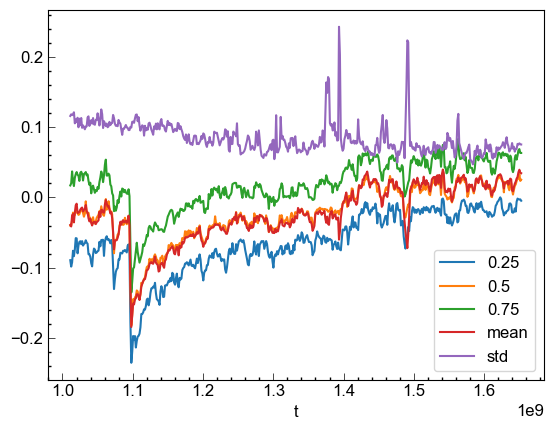

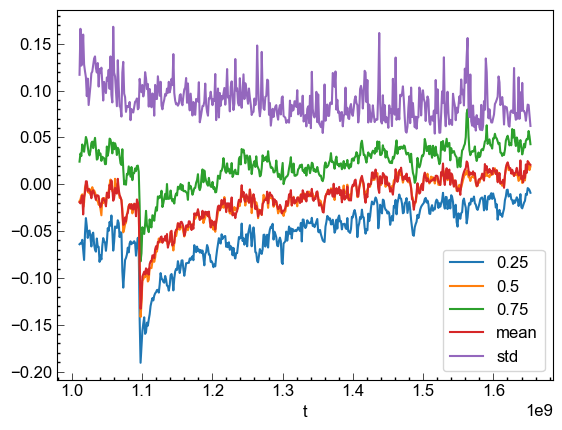

In [14]:
df_dvvfreq_stretching_stats.plot(y=df_dvvfreq_stretching_stats.columns[:-1])
df_dvvfreq_mwcs_stats.plot(y=df_dvvfreq_stretching_stats.columns[:-1])

In [15]:
# df_dvvfreq_stretching_stats.plot(y=df_dvvfreq_stretching_stats.columns[-1])
# df_dvvfreq_mwcs_stats.plot(y=df_dvvfreq_stretching_stats.columns[-1])

In [16]:
# fig, ax = plt.subplots(figsize=(10, 2))
# ax.bar(uniform_tvec, df_dvvfreq_stretching_stats["count"], width=15)
# ax.set_ylim(0, 630)
# ax.grid(True)

## Compute probabilistic power spectral density

In [17]:
ppsd_min = -0.3 # minimum bound of ppsd histrogram
ppsd_max = 0.2 # maximum bound of ppsd histrogram
ppsd_bins = 25 #20 #25 # number of bins to compute ppsd

# get bin edge
_, dvvbins =  np.histogram(df_dvvfreq_stretching.iloc[0].dropna().values, bins=ppsd_bins, range=(ppsd_min, ppsd_max), density=False, weights=None)
dvvbins_mid = [(dvvbins[i]+dvvbins[i+1])/2 for i in range(len(dvvbins)-1)]
deltadvvbin = dvvbins_mid[1] - dvvbins_mid[0]
print(f"delta dvv bin: {np.round(deltadvvbin, 6)}%")

# prepare array
ppsd_z_stretching = np.zeros((len(dvvbins)-1, len(df_dvvfreq_stretching)), float)
ppsd_z_mwcs= np.zeros((len(dvvbins)-1, len(df_dvvfreq_stretching)), float)

# compute probability mass at each time bin
# Update: use the number of station pairs instead of probability mass
for ind1, row1 in df_dvvfreq_stretching.iterrows():
    dvvval1 = row1.dropna().values
    #weights1 = np.ones_like(dvvval1) / len(dvvval1)
    hist1, _ =  np.histogram(dvvval1, bins=ppsd_bins, range=(ppsd_min, ppsd_max), density=False, weights=None)#weights1)
#     print(df_dvvfreq_stretching.index.get_loc(ind))
    ppsd_z_stretching[:, df_dvvfreq_stretching.index.get_loc(ind1)] = hist1

for ind2, row2 in df_dvvfreq_mwcs.iterrows():
    dvvval2 = row2.dropna().values
#     weights2 = np.ones_like(dvvval2) / len(dvvval2)
    hist2, _ =  np.histogram(dvvval2, bins=ppsd_bins, range=(ppsd_min, ppsd_max), density=False, weights=None)#weights1)
    ppsd_z_mwcs[:, df_dvvfreq_mwcs.index.get_loc(ind2)] = hist2
    

delta dvv bin: 0.02%


## Plot figure

In [18]:
# # compute line colormaps
# cpalette=np.array(sns.color_palette("Set2"))[1:7]
# cpalette[1, :] = np.array([0, 202, 222])/255

In [19]:
# # cmap_scatter = "rainbow" #sns.color_palette("rocket_r", as_cmap=True)

# # set colormap
# colormapname = "paracooltowarm.json"
# pcmap = importParaviewColormap(colormapname, False)

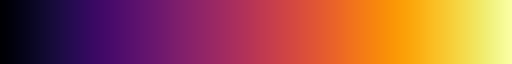

In [20]:
# compute line colormaps
whiteclip_ind = 1 #index of clip lower value with white
c1=sns.color_palette("inferno", as_cmap=True) #("YlOrBr_r", as_cmap=True)
# c1=sns.cubehelix_palette(start=0, rot=-.5, as_cmap=True)
c1 = c1(np.linspace(0, 1, 51))
# c1[:whiteclip_ind, :3] = [1, 1, 1]
# c1[:, 3] = 1 #0.25
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("c1", c1)
cmap1

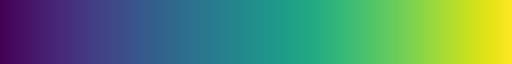

In [21]:
c2=sns.color_palette("viridis", as_cmap=True)
c2 = c2(np.linspace(0, 1, 51))
# c2[:whiteclip_ind, :3] = [1, 1, 1]
# c2[:, 3] = 1 #0.25
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("c2", c2)
cmap2

In [ ]:
# dvvdata_IsOffsetRemoval = True # remove offset from the dv/v with the periof before San Simeon eq. of the observation
dvvdata_IsOffsetRemoval=True
tSS = datetime.datetime(2003, 12, 12) # date of San Simeon earthquake
vlines = [datetime.datetime(2003, 12, 12), datetime.datetime(2004, 9, 28)] 

refstarttime = datetime.datetime(2010, 1, 1)
refendtime = datetime.datetime(2022, 6, 1)

cmap_contourf = [cmap1, cmap2] #[sns.color_palette("inferno", as_cmap=True), sns.color_palette("coolwarm", as_cmap=True)]

if dvvdata_IsOffsetRemoval:
    offset_ind = np.where(np.array(uniform_tvec) < tSS)
    offset_data1 = np.nanmean(df_dvvfreq_stretching_stats[0.5].values[offset_ind]) # offset is evaluated with the mean of median dvv
    offset_data2 = np.nanmean(df_dvvfreq_mwcs_stats[0.5].values[offset_ind]) # offset is evaluated with the mean of median dvv
else:
    offset_data1 = 0
    offset_data2 = 0
    
fig, axs = plt.subplots(2, 1, figsize=(10.5, 9.1), sharex=False, gridspec_kw={'height_ratios': [1, 1]})

# Plot stretching
axs[0].plot(uniform_tvec, df_dvvfreq_stretching_stats[0.5].values-offset_data1, "-", c="w", label="median", zorder=6, lw=1.4) # median
ybot1 =  df_dvvfreq_stretching_stats[0.25].values-offset_data1 #  1st quartile
ytop1 =  df_dvvfreq_stretching_stats[0.75].values-offset_data1 #  3rd quartile
# axs[0].fill_between(uniform_tvec, ybot1, ytop1, color=cpalette[0], alpha=0.4, label="1st and 3rd quartiles", ec="k", zorder=5)
# axs[0].fill_between(uniform_tvec, ybot1, ytop1, color=cpalette[0], alpha=1, label="1st and 3rd quartiles", ls="-", ec="k", lw=0.8)
axs[0].plot(uniform_tvec, ybot1, c="w", alpha=1, lw=0.7, ls="-", label="1st and 3rd quartiles")
axs[0].plot(uniform_tvec, ytop1, c="w", alpha=1, lw=0.7, ls="-")

# axs[0].plot(uniform_tvec, df_dvvfreq_stretching_stats["mean"].values-offset_data1, "--", c=lc_mean, label="mean", zorder=5) # mean
axs[0].set_title("stretching")

legendfc=[0.3, 0.3, 0.3]
axs[0].legend(loc=4, facecolor=legendfc, labelcolor="w")

# mwcs
axs[1].plot(uniform_tvec, df_dvvfreq_mwcs_stats[0.5].values-offset_data2, "-", c="w", label="median", zorder=6, lw=1.4) # median
ybot2 =  df_dvvfreq_mwcs_stats[0.25].values-offset_data2 #  1st quartile
ytop2 =  df_dvvfreq_mwcs_stats[0.75].values-offset_data2 #  3rd quartile
# axs[1].fill_between(uniform_tvec, ybot2, ytop2, color="w", alpha=0.75, label="", ec=None)
# axs[1].fill_between(uniform_tvec, ybot2, ytop2, color=cpalette[1], alpha=0.8, label="1st and 3rd quartiles", ls="-", ec="k", lw=1.1)
axs[1].plot(uniform_tvec, ybot2, c="w", alpha=1, lw=0.7, ls="-", label="1st and 3rd quartiles")
axs[1].plot(uniform_tvec, ytop2, c="w", alpha=1, lw=0.7, ls="-")

# axs[1].plot(uniform_tvec, df_dvvfreq_mwcs_stats["mean"].values-offset_data2, "--", c=lc_mean, label="mean", zorder=5) # mean
axs[1].set_title("MWCS")
axs[1].legend(loc=4, facecolor=legendfc, labelcolor="w")

#---Plot psd data---#
cmin = 0
cmax = 80
norm_C = mpl.colors.Normalize(vmin=cmin, vmax=cmax)

h1 = axs[0].contourf(uniform_tvec, dvvbins_mid-offset_data1, ppsd_z_stretching, 100, norm=norm_C, cmap=cmap_contourf[0])
h2 = axs[1].contourf(uniform_tvec, dvvbins_mid-offset_data2, ppsd_z_mwcs, 100, norm=norm_C, cmap=cmap_contourf[1])

#---plot zero axis---#
axs[0].axhline(0, c="w", lw=0.75, ls="--")
axs[1].axhline(0, c="w", lw=0.75, ls="--")
#-------------------------------#

xfmt = dates.DateFormatter('%Y')
for i in range(2):
    axs[i].set_ylim(-0.25, 0.15)
    axs[i].set_yticks(np.linspace(-0.20, 0.15, 8))
    axs[i].set_ylabel("dv/v [%]")
    axs[i].set_xlim(starttime, endtime)
    axs[i].grid(True, axis="both", lw=0.5, c=[0.8, 0.8, 0.8], alpha=0.4, zorder=-20)
#     plt.setp(axs[i].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    # plot the date of San Simeon and Parkfield eq.
    for vline in vlines:
        axs[i].axvline(vline,
                    color='r',
                    linewidth=1.0,
                    linestyle='--',
                    zorder=2)
        
    # period of unstable dv/v
    vlines_unstable = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 6, 1)]
    axs[i].fill_betweenx([-0.3, 0.3], vlines_unstable[0], vlines_unstable[1], fc="gray", alpha=0.7, ls="-", zorder=10)

    # annotate reference period
    refy = -0.29
    axs[i].annotate('', xy=(refstarttime, refy), xytext=(refendtime, refy), arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
    axs[i].text(datetime.datetime(2016,6,1), -0.3, "reference stack period", ha="center", va='top')
    # axs[1].plot([refstarttime, refendtime], [-0.3, -0.3], clip_on=False,)

    # annotate median and quartiles
#     axs[i].annotate("", xy=(0.538, 0.59), xytext=(0.59, 0.43), xycoords='axes fraction', arrowprops={"arrowstyle":"-|>", "color":"w"}, ha='center', va='center')
#     axs[i].text(0.6275, 0.44, 'median', ha='center', va='center', transform=axs[i].transAxes, color="w", fontsize=14)
#     axs[i].annotate("", xy=(0.538, 0.485), xytext=(0.59, 0.325), xycoords='axes fraction', arrowprops={"arrowstyle":"-|>", "color":"w"}, ha='center', va='center')
#     axs[i].text(0.5925, 0.315, '1st and 3rd\nquartiles', ha='left', va='center', transform=axs[i].transAxes, color="w", fontsize=14)


plt.tight_layout()

fig.suptitle(f'dv/v with all components {freqkey}Hz', x=0.53)
fig.tight_layout(rect=[0,0,1,1.01])
plt.subplots_adjust(hspace=0.28)
fig.align_ylabels()


# add colorbar
cb_color="w"
for i, h in enumerate([h1, h2]):
    cbaxes = axs[i].inset_axes([0.25, 0.14, 0.5, 0.25])
    cbaxes.set_axis_off()
    cbar1=plt.colorbar(mpl.cm.ScalarMappable(norm=h.norm, cmap=h.cmap), ax=cbaxes, orientation="horizontal", fraction=0.24)
    cbar1.set_label('Number of station pairs per {:.2f}% bins'.format(deltadvvbin), color=cb_color)
    cbar1.ax.xaxis.set_tick_params(color=cb_color, which="both")
    plt.setp(plt.getp(cbar1.ax.axes, 'xticklabels'), color=cb_color)

foname = (output_imgdir+f"/dvv_all_{freqkey}Hz_master.png")
plt.savefig(foname, dpi=150)

## Unstable period dueing 2017.1-2017.6

In some ccf plots, we found the large shift of cross-correlation functions (e.g. EADB-GHIB, EADB-MMNB, GHIB-VCAB; thus probably EADB and GHIB had an issue).
This could be due to the issue in the clock rather than the change in velocity. We therefore plot the mask of the period in the figure above.

# Plot the number of station pairs

In [23]:
cpalette=np.array(sns.color_palette("Set2"))[1:7]


In [ ]:
# bar plot of the count of data

fig, axs = plt.subplots(2, 1, figsize=(11, 6.5), sharex=False, gridspec_kw={'height_ratios': [1, 1]})

# Plot bar chart of count of station pairs    
axs[0].bar(uniform_tvec, df_dvvfreq_stretching_stats["count"], width=15, color=cpalette[0], alpha=0.1)
axs[0].step(uniform_tvec, df_dvvfreq_stretching_stats["count"], color=cpalette[0], where="mid",linewidth=1)
axs[0].set_title("stretching")

axs[1].bar(uniform_tvec, df_dvvfreq_mwcs_stats["count"], width=15, color=cpalette[1], alpha=0.1)
axs[1].step(uniform_tvec, df_dvvfreq_mwcs_stats["count"], color=cpalette[1], where="mid",linewidth=1)
axs[1].set_title("MWCS")

xfmt = dates.DateFormatter('%Y')
for i in range(2):
    axs[i].set_ylim(0, 600)
    axs[i].set_yticks(np.arange(100, 610, 100))
    axs[i].set_ylabel("Number of pairs")
    axs[i].set_xlim(starttime, endtime)
    axs[i].grid(True, axis="both", lw=0.5, c="gray", alpha=0.3, zorder=-1)
#     plt.setp(axs[i].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    for vline in vlines:
        axs[i].axvline(vline,
                    color='k',
                    linewidth=1.0,
                    linestyle='--',
                    zorder=2)
    axs[i].xaxis.set_major_formatter(xfmt)   
    # period of unstable dv/v
    vlines_unstable = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 6, 1)]
    axs[i].fill_betweenx([0, 600], vlines_unstable[0], vlines_unstable[1], fc="gray", alpha=0.4, ls="-", zorder=10)

    # annotate reference period
    refy = -85
    axs[i].annotate('', xy=(refstarttime, refy), xytext=(refendtime, refy), arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
    axs[i].text(datetime.datetime(2016,6,1), -100, "reference stack period", ha="center", va='top')
    
    
plt.tight_layout()
fig.suptitle(f'dv/v with all pairs {freqkey}Hz', x=0.525)
fig.tight_layout(rect=[0,0,1,1.02])
plt.subplots_adjust(hspace=0.4)
fig.align_ylabels()

foname = (output_imgdir+f"/dvv_all_{freqkey}Hz_numberofpairs.png")
plt.savefig(foname, dpi=150)

## Plot number of pairs with compact figure as master plot

In [ ]:
# bar plot of the count of data

fig, axs = plt.subplots(2, 1, figsize=(6.7, 6.5), sharex=False, gridspec_kw={'height_ratios': [1, 1]})

# Plot bar chart of count of station pairs    
axs[0].bar(uniform_tvec, df_dvvfreq_stretching_stats["count"], width=15, color=cpalette[0], alpha=0.1)
axs[0].step(uniform_tvec, df_dvvfreq_stretching_stats["count"], color=cpalette[0], where="mid",linewidth=1)
axs[0].set_title("stretching")

axs[1].bar(uniform_tvec, df_dvvfreq_mwcs_stats["count"], width=15, color=cpalette[1], alpha=0.1)
axs[1].step(uniform_tvec, df_dvvfreq_mwcs_stats["count"], color=cpalette[1], where="mid",linewidth=1)
axs[1].set_title("MWCS")

xfmt = dates.DateFormatter('%Y')
for i in range(2):
    axs[i].set_ylim(0, 600)
    axs[i].set_yticks(np.arange(100, 610, 100))
    axs[i].set_ylabel("Number of pairs")
    axs[i].set_xlim(starttime, endtime)
    axs[i].grid(True, axis="both", lw=0.5, c="gray", alpha=0.3, zorder=-1)
#     plt.setp(axs[i].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    for vline in vlines:
        axs[i].axvline(vline,
                    color='k',
                    linewidth=1.0,
                    linestyle='--',
                    zorder=2)
    axs[i].xaxis.set_major_formatter(xfmt)   
    # period of unstable dv/v
    vlines_unstable = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 6, 1)]
    axs[i].fill_betweenx([0, 600], vlines_unstable[0], vlines_unstable[1], fc="gray", alpha=0.4, ls="-", zorder=10)

    # annotate reference period
    refy = -85
    axs[i].annotate('', xy=(refstarttime, refy), xytext=(refendtime, refy), arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
    axs[i].text(datetime.datetime(2016,6,1), -100, "reference stack period", ha="center", va='top')
    
    
plt.tight_layout()
fig.suptitle(f'dv/v with all pairs {freqkey}Hz', x=0.525)
fig.tight_layout(rect=[0,0,1,1.02])
plt.subplots_adjust(hspace=0.4)
fig.align_ylabels()

foname = (output_imgdir+f"/dvv_all_{freqkey}Hz_numberofpairs_compact.png")
plt.savefig(foname, dpi=150)

In [26]:
# compute mean number
print(df_dvvfreq_stretching_stats["count"].mean(), df_dvvfreq_mwcs_stats["count"].mean())

390.8991935483871 369.33266129032256


# Plot with different station and channel pairs

We compare the four cases

1. auto-correlation of stations (single station), including all the auto- and cross-channel pairs
2. cross-correlation of stations (cross station), including all the auto- and cross-channel pairs
3. all the station pairs with vertical component ("11")
4. all the station pairs with horizontal component ("22", "23", "32", "33")

In [27]:
stationpairs = np.unique(df_dvvfreq_stretching.columns.get_level_values(1))
singlestation_list = []
crossstation_list = []

for stationpair in stationpairs:
#     print(stationpair)
    sta1, sta2 = [x.split(".")[-1] for x in stationpair.split("-")]
    if sta1 == sta2:
        #single-station correlation
        singlestation_list.append(stationpair)
    else:
        crossstation_list.append(stationpair)

In [28]:
# crossstation_list

In [29]:
complist_vertical = ["11"]
complist_horizontal = ["22", "23", "32", "33"]
complist_upper = ['11', '22', '33', '12', '13', '23'] # debug: upper is for the comparison with our own previous works
corr_columnlist = ["single-station", "cross-stations", "vertical component", "horizontal components", "upper"] 

In [30]:
# test to extract components
df_dvvfreq_stretching.loc[:, df_dvvfreq_stretching.columns.get_level_values("components").isin(["11", "23"])].head()

freqband             0.9-1.2                                               
stationpair  BP.CCRB-BP.CCRB     BP.CCRB-BP.EADB     BP.CCRB-BP.FROB       
components                11  23              11  23              11  23   
t                                                                          
1.011139e+09             NaN NaN             NaN NaN             NaN NaN  \
1.012435e+09             NaN NaN             NaN NaN             NaN NaN   
1.013731e+09             NaN NaN             NaN NaN             NaN NaN   
1.015027e+09             NaN NaN             NaN NaN             NaN NaN   
1.016323e+09             NaN NaN             NaN NaN             NaN NaN   

freqband                                              ...                       
stationpair  BP.CCRB-BP.JCNB     BP.CCRB-BP.JCSB      ... BP.SMNB-BP.VARB       
components                11  23              11  23  ...              11  23   
t                                                     ...                       
1.011139e+09             NaN NaN             NaN NaN  ...             NaN NaN  \
1.012435e+09             NaN NaN             NaN NaN  ...             NaN NaN   
1.013731e+09             NaN NaN             NaN NaN  ...             NaN NaN   
1.015027e+09             NaN NaN             NaN NaN  ...             NaN NaN   
1.016323e+09             NaN NaN             NaN NaN  ...       -0.035872 NaN   

freqband                                                                     
stationpair  BP.SMNB-BP.VCAB           BP.VARB-BP.VARB     BP.VARB-BP.VCAB   
components                11        23              11  23              11   
t                                                                            
1.011139e+09       -0.164770 -0.124409       -0.012024 NaN             NaN  \
1.012435e+09       -0.145611 -0.178517       -0.006573 NaN             NaN   
1.013731e+09       -0.127535 -0.158397             NaN NaN             NaN   
1.015027e+09       -0.000681 -0.067655             NaN NaN             NaN   
1.016323e+09       -0.015511 -0.078637             NaN NaN             NaN   

freqband                                    
stationpair      BP.VCAB-BP.VCAB            
components    23              11        23  
t                                           
1.011139e+09 NaN       -0.143447 -0.063447  
1.012435e+09 NaN       -0.142966 -0.085371  
1.013731e+09 NaN       -0.119719 -0.045972  
1.015027e+09 NaN       -0.066814 -0.035511  
1.016323e+09 NaN       -0.039599 -0.053948  

[5 rows x 166 columns]

In [31]:
df_dvvfreq_stretching.loc[:, df_dvvfreq_stretching.columns.get_level_values("stationpair").isin(singlestation_list)].head()

freqband             0.9-1.2                                                   
stationpair  BP.CCRB-BP.CCRB                                 BP.EADB-BP.EADB   
components                11  12  13  21  22  23  31  32  33              11   
t                                                                              
1.011139e+09             NaN NaN NaN NaN NaN NaN NaN NaN NaN       -0.054188  \
1.012435e+09             NaN NaN NaN NaN NaN NaN NaN NaN NaN       -0.162605   
1.013731e+09             NaN NaN NaN NaN NaN NaN NaN NaN NaN       -0.096593   
1.015027e+09             NaN NaN NaN NaN NaN NaN NaN NaN NaN       -0.033828   
1.016323e+09             NaN NaN NaN NaN NaN NaN NaN NaN NaN       -0.021042   

freqband      ...                                                       
stationpair   ... BP.VARB-BP.VARB BP.VCAB-BP.VCAB                       
components    ...              33              11        12        13   
t             ...                                                       
1.011139e+09  ...             NaN       -0.143447 -0.029218 -0.140561  \
1.012435e+09  ...             NaN       -0.142966 -0.024409 -0.152625   
1.013731e+09  ...             NaN       -0.119719 -0.048136 -0.139599   
1.015027e+09  ...             NaN       -0.066814 -0.035992 -0.096112   
1.016323e+09  ...             NaN       -0.039599 -0.026814 -0.118277   

freqband                                                                  
stationpair                                                               
components          21        22        23        31        32        33  
t                                                                         
1.011139e+09 -0.032385 -0.016473 -0.063447 -0.139359 -0.060802 -0.021764  
1.012435e+09 -0.025731 -0.015030 -0.085371 -0.149098 -0.081523 -0.024168  
1.013731e+09 -0.049579 -0.016353 -0.045972 -0.138878 -0.043327 -0.049218  
1.015027e+09 -0.035872 -0.008858 -0.035511 -0.095271 -0.033948 -0.024890  
1.016323e+09 -0.026333 -0.073347 -0.053948 -0.118397 -0.052385  0.010902  

[5 rows x 117 columns]

In [32]:
for i, corrlist in enumerate([singlestation_list, crossstation_list, complist_vertical, complist_horizontal, complist_upper]):
    if len(corrlist[0]) == 15:
        # cases for single- and cross-correlation
        df_dvvcomp_stretching = df_dvvfreq_stretching.loc[:, df_dvvfreq_stretching.columns.get_level_values("stationpair").isin(corrlist)]
        df_dvvcomp_mwcs = df_dvvfreq_mwcs.loc[:, df_dvvfreq_mwcs.columns.get_level_values("stationpair").isin(corrlist)]
        
    else:
        # cases for vertical and horizontal components
        df_dvvcomp_stretching = df_dvvfreq_stretching.loc[:, df_dvvfreq_stretching.columns.get_level_values("components").isin(corrlist)]
        df_dvvcomp_mwcs = df_dvvfreq_mwcs.loc[:, df_dvvfreq_mwcs.columns.get_level_values("components").isin(corrlist)]
    
    #stretching
    df_dvvcomp_stretching_stats = df_dvvcomp_stretching.quantile([0.25, 0.5, 0.75], axis=1).T # 1st, 2nd, and 3rd quartiles
    df_dvvcomp_stretching_stats.loc[:, "mean"] = df_dvvcomp_stretching.mean(skipna=True, axis=1).T #mean
    df_dvvcomp_stretching_stats.loc[:, "std"] = df_dvvcomp_stretching.std(skipna=True, axis=1).T #std
    df_dvvcomp_stretching_stats.loc[:, "count"] = df_dvvcomp_stretching.count(axis=1).T #number of data with each time window
    df_dvvcomp_stretching_stats.columns = pd.MultiIndex.from_tuples([(corr_columnlist[i], x) for x in df_dvvcomp_stretching_stats.columns], names=['comptype', 'stats'])
    if i==0:
        # initialize dataframe
        df_dvvcomp_stretching_stats_all = df_dvvcomp_stretching_stats 
    else:
        df_dvvcomp_stretching_stats_all = pd.concat([df_dvvcomp_stretching_stats_all, df_dvvcomp_stretching_stats], axis=1, sort=True)

    #mwcs
    df_dvvcomp_mwcs_stats = df_dvvcomp_mwcs.quantile([0.25, 0.5, 0.75], axis=1).T # 1st, 2nd, and 3rd quartiles
    df_dvvcomp_mwcs_stats.loc[:, "mean"] = df_dvvcomp_mwcs.mean(skipna=True, axis=1).T #mean
    df_dvvcomp_mwcs_stats.loc[:, "std"] = df_dvvcomp_mwcs.std(skipna=True, axis=1).T #std
    df_dvvcomp_mwcs_stats.loc[:, "count"] = df_dvvcomp_mwcs.count(axis=1).T #number of data with each time window
    df_dvvcomp_mwcs_stats.columns = pd.MultiIndex.from_tuples([(corr_columnlist[i], x) for x in df_dvvcomp_mwcs_stats.columns], names=['comptype', 'stats'])
#     df_dvvcomp_mwcs_stats_all = pd.concat([df_dvvcomp_mwcs_stats_all, df_dvvcomp_mwcs_stats], sort=True)
    if i==0:
        # initialize dataframe
        df_dvvcomp_mwcs_stats_all = df_dvvcomp_mwcs_stats 
    else:
        df_dvvcomp_mwcs_stats_all = pd.concat([df_dvvcomp_mwcs_stats_all, df_dvvcomp_mwcs_stats], axis=1, sort=True)


In [33]:
# df_dvvcomp_stretching_stats_all.columns

## Plot comparisons

In the comparison between different pairs, we only plot percentiles for ease of visualization.

In [34]:
cpalette_comp=np.array(sns.color_palette("colorblind"))[:]

# labels for legend
complabels=["single-station", "cross-stations", "vertical component", "horizontal components"]

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10.5, 7.1), sharex=False, gridspec_kw={'height_ratios': [1, 1]}) #(10.5, 9.1)

dvvdata_IsOffsetRemoval=True

# comptype = comp_columnlist[0]
for i, comptype in enumerate(corr_columnlist[:-1]):
#     if i in [0, 1]:
#         continue;
        
    dvv_comp_stretching = df_dvvcomp_stretching_stats_all.loc[:, comptype]
    dvv_comp_mwcs = df_dvvcomp_mwcs_stats_all.loc[:, comptype]

    if dvvdata_IsOffsetRemoval:
        offset_ind = np.where(np.array(uniform_tvec) < tSS)
        offset_data1 = np.nanmean(dvv_comp_stretching[0.5].values[offset_ind]) # offset is evaluated with the mean of median dvv
        offset_data2 = np.nanmean(dvv_comp_mwcs[0.5].values[offset_ind]) # offset is evaluated with the mean of median dvv
    else:
        offset_data1 = 0
        offset_data2 = 0

    # Plot stretching
    axs[0].plot(uniform_tvec, dvv_comp_stretching[0.5].values-offset_data1, "-", c=cpalette_comp[i], label=complabels[i], zorder=6, lw=1.4) # median
    ybot1 =  dvv_comp_stretching[0.25].values-offset_data1 #  1st quartile
    ytop1 =  dvv_comp_stretching[0.75].values-offset_data1 #  3rd quartile
    axs[0].fill_between(uniform_tvec, ybot1, ytop1, color=cpalette_comp[i], alpha=0.1, label="", ec="k", lw=0.5, zorder=5)
    axs[0].plot(uniform_tvec, ybot1, c=cpalette_comp[i], alpha=0.1, lw=0.7, ls="-")
    axs[0].plot(uniform_tvec, ytop1, c=cpalette_comp[i], alpha=0.1, lw=0.7, ls="-")
    axs[0].legend(loc=4, labelcolor="k", fontsize=11)

    # mwcs
    axs[1].plot(uniform_tvec, dvv_comp_mwcs[0.5].values-offset_data2, "-", c=cpalette_comp[i], label=complabels[i], zorder=6, lw=1.4) # median
    ybot2 =  dvv_comp_mwcs[0.25].values-offset_data2 #  1st quartile
    ytop2 =  dvv_comp_mwcs[0.75].values-offset_data2 #  3rd quartile
    axs[1].fill_between(uniform_tvec, ybot2, ytop2, color=cpalette_comp[i], alpha=0.1, label="", ec="k", lw=0.5, zorder=5)
    axs[1].plot(uniform_tvec, ybot2, c=cpalette_comp[i], alpha=0.1, lw=0.7, ls="-")
    axs[1].plot(uniform_tvec, ytop2, c=cpalette_comp[i], alpha=0.1, lw=0.7, ls="-")
    axs[1].legend(loc=4, labelcolor="k", fontsize=11)

axs[0].set_title("stretching")
axs[1].set_title("MWCS")



xfmt = dates.DateFormatter('%Y')
for i in range(2):
    axs[i].set_ylim(-0.25, 0.15)
    axs[i].set_yticks(np.linspace(-0.20, 0.15, 8))
    axs[i].set_ylabel("dv/v [%]")
    axs[i].set_xlim(starttime, endtime)
    axs[i].grid(True, axis="both", lw=0.5, c=[0.8, 0.8, 0.8], alpha=0.4, zorder=-20)
    axs[i].axhline(0, c="k", lw=0.75, ls="--")

#     plt.setp(axs[i].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    # plot the date of San Simeon and Parkfield eq.
    for vline in vlines:
        axs[i].axvline(vline,
                    color='k',
                    linewidth=1.0,
                    linestyle='--',
                    zorder=2)
        
    # period of unstable dv/v
    vlines_unstable = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 6, 1)]
    axs[i].fill_betweenx([-0.3, 0.3], vlines_unstable[0], vlines_unstable[1], fc="gray", alpha=0.7, ls="-", zorder=10)

    # annotate reference period
    refy = -0.3
    axs[i].annotate('', xy=(refstarttime, refy), xytext=(refendtime, refy), arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
    axs[i].text(datetime.datetime(2016,6,1), -0.31, "reference stack period", ha="center", va='top')
    # axs[1].plot([refstarttime, refendtime], [-0.3, -0.3], clip_on=False,)



plt.tight_layout()

fig.suptitle(f'dv/v with different components {freqkey}Hz', x=0.53)
fig.tight_layout(rect=[0,0,1,1.01])
plt.subplots_adjust(hspace=0.35)
fig.align_ylabels()

foname = (output_imgdir+f"/dvv_differentcomp_{freqkey}Hz.png")
plt.savefig(foname, dpi=150)

## bar plot of the count of data

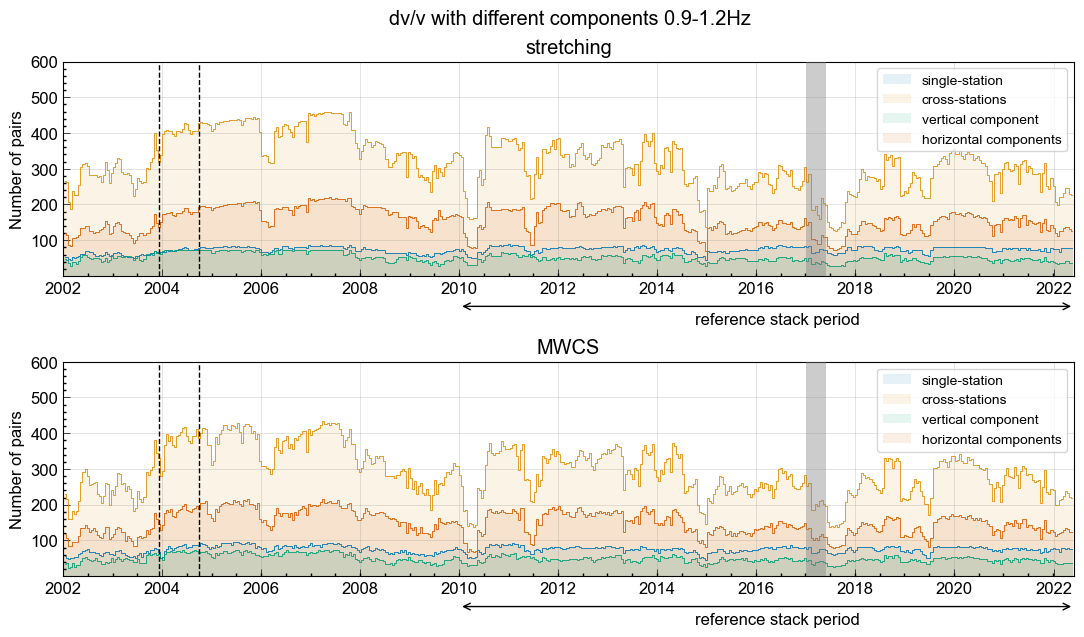

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(11, 6.5), sharex=False, gridspec_kw={'height_ratios': [1, 1]})

for i, comptype in enumerate(corr_columnlist[:-1]):
    dffcomp_stretching = df_dvvcomp_stretching_stats_all.loc[:, comptype]
    dffcomp_mwcs = df_dvvcomp_mwcs_stats_all.loc[:, comptype]

    # Plot bar chart of count of station pairs    
    axs[0].bar(uniform_tvec, dffcomp_stretching["count"], width=15, color=cpalette_comp[i], alpha=0.1, label=complabels[i])
    axs[0].step(uniform_tvec, dffcomp_stretching["count"], color=cpalette_comp[i],where="mid",linewidth=0.6)
    axs[0].set_title("stretching")

    axs[1].bar(uniform_tvec, dffcomp_mwcs["count"], width=15, color=cpalette_comp[i], alpha=0.1, label=complabels[i])
    axs[1].step(uniform_tvec, dffcomp_mwcs["count"], color=cpalette_comp[i], where="mid",linewidth=0.6)
    axs[1].set_title("MWCS")

xfmt = dates.DateFormatter('%Y')
for i in range(2):
    axs[i].set_ylim(0, 600)
    axs[i].set_yticks(np.arange(100, 610, 100))
    axs[i].set_ylabel("Number of pairs")
    axs[i].set_xlim(starttime, endtime)
    axs[i].grid(True, axis="both", lw=0.5, c="gray", alpha=0.3, zorder=-1)

#     plt.setp(axs[i].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    for vline in vlines:
        axs[i].axvline(vline,
                    color='k',
                    linewidth=1.0,
                    linestyle='--',
                    zorder=2)
    axs[i].xaxis.set_major_formatter(xfmt)   
    # period of unstable dv/v
    vlines_unstable = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 6, 1)]
    axs[i].fill_betweenx([0, 600], vlines_unstable[0], vlines_unstable[1], fc="gray", alpha=0.4, ls="-", zorder=10)

    # annotate reference period
    refy = -85
    axs[i].annotate('', xy=(refstarttime, refy), xytext=(refendtime, refy), arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
    axs[i].text(datetime.datetime(2016,6,1), -100, "reference stack period", ha="center", va='top')
    axs[i].legend(loc=1, labelcolor="k", fontsize=10)

    
plt.tight_layout()
fig.suptitle(f'dv/v with different components {freqkey}Hz', x=0.525)
fig.tight_layout(rect=[0,0,1,1.02])
plt.subplots_adjust(hspace=0.4)
fig.align_ylabels()

foname = (output_imgdir+f"/dvv_differentcomp_{freqkey}Hz_numberofpairs.png")
plt.savefig(foname, dpi=150)

# Plot with different freqneucy ranges

In [37]:
freqkeys

array(['0.2-0.5', '0.5-0.9', '0.9-1.2', '1.2-2.0'], dtype=object)

In [38]:
freqlabels = [x+"Hz" for x in freqkeys]

In [39]:
cpalette_freq=np.array(sns.color_palette("colorblind"))[:]
cpalette_freq

array([[0.00392157, 0.45098039, 0.69803922],
       [0.87058824, 0.56078431, 0.01960784],
       [0.00784314, 0.61960784, 0.45098039],
       [0.83529412, 0.36862745, 0.        ],
       [0.8       , 0.47058824, 0.7372549 ],
       [0.79215686, 0.56862745, 0.38039216],
       [0.98431373, 0.68627451, 0.89411765],
       [0.58039216, 0.58039216, 0.58039216],
       [0.9254902 , 0.88235294, 0.2       ],
       [0.3372549 , 0.70588235, 0.91372549]])

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10.5, 7.1), sharex=False, gridspec_kw={'height_ratios': [1, 1]}) #(10.5, 9.1)
dvvdata_IsOffsetRemoval=True

for i, freqkey in enumerate(freqkeys):
    #---Extract the date with the freqkey---#
    df_dvvfreq_stretching = df_stretching.loc[:, "dvv"].loc[:, df_stretching.loc[:, "dvv"].columns.get_level_values("freqband")==freqkey]
    df_ccfreq_stretching = df_stretching.loc[:, "cc_dvv"].loc[:, df_stretching.loc[:, "cc_dvv"].columns.get_level_values("freqband")==freqkey]
    df_errfreq_stretching = df_stretching.loc[:, "err"].loc[:, df_stretching.loc[:, "err"].columns.get_level_values("freqband")==freqkey]

    df_dvvfreq_mwcs = df_mwcs.loc[:, "dvv"].loc[:, df_mwcs.loc[:, "dvv"].columns.get_level_values("freqband")==freqkey]
    df_ccfreq_mwcs = df_mwcs.loc[:, "cc_dvv"].loc[:, df_mwcs.loc[:, "cc_dvv"].columns.get_level_values("freqband")==freqkey]
    df_errfreq_mwcs = df_mwcs.loc[:, "err"].loc[:, df_mwcs.loc[:, "err"].columns.get_level_values("freqband")==freqkey]

    #---Threshold out the dvv with cc and err for the cases with stretching and mwcs, respectively---#
    df_dvvfreq_stretching.mask(df_ccfreq_stretching < cc_threshold, inplace=True)
    df_dvvfreq_mwcs.mask(df_errfreq_mwcs > err_mwcs_eps, inplace=True)


    #---Compute stats---#
    df_dvvfreq_stretching_stats = df_dvvfreq_stretching.quantile([0.25, 0.5, 0.75], axis=1).T # 1st, 2nd, and 3rd quartiles
    df_dvvfreq_stretching_stats.loc[:, "mean"] = df_dvvfreq_stretching.mean(skipna=True, axis=1).T #mean
    df_dvvfreq_stretching_stats.loc[:, "std"] = df_dvvfreq_stretching.std(skipna=True, axis=1).T #std
    df_dvvfreq_stretching_stats.loc[:, "count"] = df_dvvfreq_stretching.count(axis=1).T #number of data with each time window

    df_dvvfreq_mwcs_stats = df_dvvfreq_mwcs.quantile([0.25, 0.5, 0.75], axis=1).T # 1st, 2nd, and 3rd quartiles
    df_dvvfreq_mwcs_stats.loc[:, "mean"] = df_dvvfreq_mwcs.mean(skipna=True, axis=1).T #mean
    df_dvvfreq_mwcs_stats.loc[:, "std"] = df_dvvfreq_mwcs.std(skipna=True, axis=1).T #std
    df_dvvfreq_mwcs_stats.loc[:, "count"] = df_dvvfreq_mwcs.count(axis=1).T #number of data with each time window


    #---plot dvv---#
    if dvvdata_IsOffsetRemoval:
        offset_ind = np.where(np.array(uniform_tvec) < tSS)
        offset_data1 = np.nanmean(df_dvvfreq_stretching_stats[0.5].values[offset_ind]) # offset is evaluated with the mean of median dvv
        offset_data2 = np.nanmean(df_dvvfreq_mwcs_stats[0.5].values[offset_ind]) # offset is evaluated with the mean of median dvv
    else:
        offset_data1 = 0
        offset_data2 = 0

    # Plot stretching
    if i==0:
        print(f"skip plotting stretching {freqkey}Hz due to the instability in the dv/v measurement.")
    else:
        axs[0].plot(uniform_tvec, df_dvvfreq_stretching_stats[0.5].values-offset_data1, "-", c=cpalette_freq[i], label=freqlabels[i], zorder=6, lw=1.4) # median
        ybot1 =  df_dvvfreq_stretching_stats[0.25].values-offset_data1 #  1st quartile
        ytop1 =  df_dvvfreq_stretching_stats[0.75].values-offset_data1 #  3rd quartile
        axs[0].fill_between(uniform_tvec, ybot1, ytop1, color=cpalette_freq[i], alpha=0.1, label="", ec="k", lw=0.5, zorder=5)
        axs[0].plot(uniform_tvec, ybot1, c=cpalette_freq[i], alpha=0.1, lw=0.7, ls="-")
        axs[0].plot(uniform_tvec, ytop1, c=cpalette_freq[i], alpha=0.1, lw=0.7, ls="-")
        axs[0].legend(loc=4, labelcolor="k", fontsize=11)

    # mwcs
    axs[1].plot(uniform_tvec, df_dvvfreq_mwcs_stats[0.5].values-offset_data2, "-", c=cpalette_freq[i], label=freqlabels[i], zorder=6, lw=1.4) # median
    ybot2 =  df_dvvfreq_mwcs_stats[0.25].values-offset_data2 #  1st quartile
    ytop2 =  df_dvvfreq_mwcs_stats[0.75].values-offset_data2 #  3rd quartile
    axs[1].fill_between(uniform_tvec, ybot2, ytop2, color=cpalette_freq[i], alpha=0.1, label="", ec="k", lw=0.5, zorder=5)
    axs[1].plot(uniform_tvec, ybot2, c=cpalette_freq[i], alpha=0.1, lw=0.7, ls="-")
    axs[1].plot(uniform_tvec, ytop2, c=cpalette_freq[i], alpha=0.1, lw=0.7, ls="-")
    axs[1].legend(loc=4, labelcolor="k", fontsize=11)

    axs[0].set_title("stretching")
    axs[1].set_title("MWCS")




xfmt = dates.DateFormatter('%Y')
for i in range(2):
    axs[i].set_ylim(-0.25, 0.15)
    axs[i].set_yticks(np.linspace(-0.20, 0.15, 8))
    axs[i].set_ylabel("dv/v [%]")
    axs[i].set_xlim(starttime, endtime)
    axs[i].grid(True, axis="both", lw=0.5, c=[0.8, 0.8, 0.8], alpha=0.4, zorder=-20)
    axs[i].axhline(0, c="k", lw=0.75, ls="--")

#     plt.setp(axs[i].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    # plot the date of San Simeon and Parkfield eq.
    for vline in vlines:
        axs[i].axvline(vline,
                    color='k',
                    linewidth=1.0,
                    linestyle='--',
                    zorder=2)
        
    # period of unstable dv/v
    vlines_unstable = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 6, 1)]
    axs[i].fill_betweenx([-0.3, 0.3], vlines_unstable[0], vlines_unstable[1], fc="gray", alpha=0.7, ls="-", zorder=10)

    # annotate reference period
    refy = -0.3
    axs[i].annotate('', xy=(refstarttime, refy), xytext=(refendtime, refy), arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
    axs[i].text(datetime.datetime(2016,6,1), -0.31, "reference stack period", ha="center", va='top')
    # axs[1].plot([refstarttime, refendtime], [-0.3, -0.3], clip_on=False,)



plt.tight_layout()

fig.suptitle(f'dv/v with different frequencies', x=0.53)
fig.tight_layout(rect=[0,0,1,1.01])
plt.subplots_adjust(hspace=0.35)
fig.align_ylabels()

foname = (output_imgdir+f"/dvv_differentfrequencies_{freqkey}Hz.png")
plt.savefig(foname, dpi=150)

### Compute the slope with different frequency bands
We evaluate the slope of long-term increase after 2012.

In [ ]:
linregress_st = datetime.datetime(2012, 1, 1)
linregress_et = datetime.datetime(2022, 6, 1)
dvvdata_IsOffsetRemoval=True


fitinds = np.where((np.array(uniform_tvec) > linregress_st) & (np.array(uniform_tvec) < linregress_et))[0]

unix_t = np.array([x.timestamp() for x in uniform_tvec])

res_dict = dict()

# res_comp_dict[freqkey] = stats.linregress(df_dvvstrain_method[comp][mask]*1e-6, df_dvvstrain_method.dvv[mask]*1e-2)
fig, axs = plt.subplots(4, 2, figsize=(12, 10))

for i, freqkey in enumerate(freqkeys):

#---Extract the date with the freqkey---#
#     i = 2
#     freqkey = freqkeys[i]

    df_dvvfreq_stretching = df_stretching.loc[:, "dvv"].loc[:, df_stretching.loc[:, "dvv"].columns.get_level_values("freqband")==freqkey]
    df_ccfreq_stretching = df_stretching.loc[:, "cc_dvv"].loc[:, df_stretching.loc[:, "cc_dvv"].columns.get_level_values("freqband")==freqkey]
    df_errfreq_stretching = df_stretching.loc[:, "err"].loc[:, df_stretching.loc[:, "err"].columns.get_level_values("freqband")==freqkey]

    df_dvvfreq_mwcs = df_mwcs.loc[:, "dvv"].loc[:, df_mwcs.loc[:, "dvv"].columns.get_level_values("freqband")==freqkey]
    df_ccfreq_mwcs = df_mwcs.loc[:, "cc_dvv"].loc[:, df_mwcs.loc[:, "cc_dvv"].columns.get_level_values("freqband")==freqkey]
    df_errfreq_mwcs = df_mwcs.loc[:, "err"].loc[:, df_mwcs.loc[:, "err"].columns.get_level_values("freqband")==freqkey]

    #---Threshold out the dvv with cc and err for the cases with stretching and mwcs, respectively---#
    df_dvvfreq_stretching.mask(df_ccfreq_stretching < cc_threshold, inplace=True)
    df_dvvfreq_mwcs.mask(df_errfreq_mwcs > err_mwcs_eps, inplace=True)

    #---Compute stats---#
    df_dvvfreq_stretching_stats = df_dvvfreq_stretching.quantile([0.25, 0.5, 0.75], axis=1).T # 1st, 2nd, and 3rd quartiles
    df_dvvfreq_stretching_stats.loc[:, "mean"] = df_dvvfreq_stretching.mean(skipna=True, axis=1).T #mean
    df_dvvfreq_stretching_stats.loc[:, "std"] = df_dvvfreq_stretching.std(skipna=True, axis=1).T #std
    df_dvvfreq_stretching_stats.loc[:, "count"] = df_dvvfreq_stretching.count(axis=1).T #number of data with each time window

    df_dvvfreq_mwcs_stats = df_dvvfreq_mwcs.quantile([0.25, 0.5, 0.75], axis=1).T # 1st, 2nd, and 3rd quartiles
    df_dvvfreq_mwcs_stats.loc[:, "mean"] = df_dvvfreq_mwcs.mean(skipna=True, axis=1).T #mean
    df_dvvfreq_mwcs_stats.loc[:, "std"] = df_dvvfreq_mwcs.std(skipna=True, axis=1).T #std
    df_dvvfreq_mwcs_stats.loc[:, "count"] = df_dvvfreq_mwcs.count(axis=1).T #number of data with each time window

    #---plot dvv---#
    if dvvdata_IsOffsetRemoval:
        offset_ind = np.where(np.array(uniform_tvec) < tSS)
        offset_data1 = np.nanmean(df_dvvfreq_stretching_stats[0.5].values[offset_ind]) # offset is evaluated with the mean of median dvv
        offset_data2 = np.nanmean(df_dvvfreq_mwcs_stats[0.5].values[offset_ind]) # offset is evaluated with the mean of median dvv
    else:
        offset_data1 = 0
        offset_data2 = 0

    #---Compute slope---#
    y_stretching = (df_dvvfreq_stretching_stats[0.5].values-offset_data1)[fitinds]
    y_mwcs = (df_dvvfreq_mwcs_stats[0.5].values-offset_data2)[fitinds]
    res_dict[f"stretching_{freqkey}"] = stats.linregress(unix_t[fitinds], y_stretching)
    res_dict[f"mwcs_{freqkey}"] = stats.linregress(unix_t[fitinds], y_mwcs)

    b_stretching = res_dict[f"stretching_{freqkey}"].slope * 86400 * 365 #[%/sec] -> [%/year]
    b_mwcs = res_dict[f"mwcs_{freqkey}"].slope * 86400 * 365   #[%/sec] -> [%/year]
    yfit_stretch = unix_t * res_dict[f"stretching_{freqkey}"].slope + res_dict[f"stretching_{freqkey}"].intercept
    yfit_mwcs = unix_t * res_dict[f"mwcs_{freqkey}"].slope + res_dict[f"mwcs_{freqkey}"].intercept
    
    if i == 0:
        # dashed line for the case with stretching
        ls_stretch = ":"
        alpha_stretch = 0.3
    else:
        ls_stretch = "-"
        alpha_stretch = 1.0
        
    axs[i, 0].plot(uniform_tvec, df_dvvfreq_stretching_stats[0.5].values-offset_data1, ls=ls_stretch, c=cpalette_freq[0], label=freqlabels[i], zorder=0, lw=1.4, alpha=alpha_stretch) # median  
    axs[i, 1].plot(uniform_tvec, df_dvvfreq_mwcs_stats[0.5].values-offset_data2, "-", c=cpalette_freq[1], label=freqlabels[i], zorder=0, lw=1.4) # median

    axs[i, 0].plot(uniform_tvec, yfit_stretch, "--", c="k", label=None, zorder=6, lw=1.4) # median  
    axs[i, 1].plot(uniform_tvec, yfit_mwcs, "--", c="k", label=None, zorder=6, lw=1.4) # median

    axs[i, 0].set_title(fr"stretching: $b_0$ = {b_stretching:.4f}[%/year]")
    axs[i, 1].set_title(fr"MWCS: $b_0$ = {b_mwcs:.4f}[%/year]")
    
    for j in range(2):
    #     axs[j].set_title(freqkey+"Hz")
        axs[i, j].set_ylim(-0.25, 0.15)
        axs[i, j].set_yticks(np.linspace(-0.20, 0.15, 8))
        axs[i, j].set_ylabel("dv/v [%]")
        axs[i, j].set_xlim(starttime, endtime)
        axs[i, j].legend(loc=4)
        axs[i, j].grid(True, axis="both", lw=0.5, c=[0.8, 0.8, 0.8], alpha=0.4, zorder=-20)
        axs[i, j].axhline(0, c="k", lw=0.75, ls="--")
        axs[i, j].axvline(linregress_st, c="r", lw=1, ls="--")
        axs[i, j].axvline(linregress_et-datetime.timedelta(30), c="r", lw=1, ls="--")

    plt.tight_layout()

    foname = (output_imgdir+f"/slope_of_dvv_differentfrequencies_allfreq.png")
    plt.savefig(foname, dpi=150)


In [42]:
# b_stretching = res_dict[f"stretching_{freqkey}"]["slope"] * 86400 * 365 #[1/sec] -> [1/year]
res_dict[f"stretching_{freqkey}"].slope

1.5755050394968105e-10

In [43]:
res_dict

{'stretching_0.2-0.5': LinregressResult(slope=-4.910947423897553e-11, intercept=0.035870319745030584, rvalue=-0.012717467311584607, pvalue=0.8404717145245667, stderr=2.437208426283716e-10, intercept_stderr=0.36372115101948727),
 'mwcs_0.2-0.5': LinregressResult(slope=-1.0729114165935756e-11, intercept=0.0178404012289816, rvalue=-0.0877794137817082, pvalue=0.1639250180720192, stderr=7.685191288738679e-12, intercept_stderr=0.011469132435288779),
 'stretching_0.5-0.9': LinregressResult(slope=9.386544026728557e-11, intercept=-0.10234780398841398, rvalue=0.45837280880501396, pvalue=1.5105389220073303e-14, stderr=1.1487738012804825e-11, intercept_stderr=0.01714393093166373),
 'mwcs_0.5-0.9': LinregressResult(slope=5.2147528872150206e-11, intercept=-0.06296786512559657, rvalue=0.5471111363972567, pvalue=3.728772913585048e-21, stderr=5.035909241747748e-12, intercept_stderr=0.007515429070754983),
 'stretching_0.9-1.2': LinregressResult(slope=1.3666608993993923e-10, intercept=-0.1746112382235953

In [44]:
df_freqslope = pd.DataFrame(columns=["dvvmethod", "freqkey", "b_slope", "b_err"])
for i, freqkey in enumerate(freqkeys):
    d_stretching = dict(dvvmethod=["stretching"], freqkey=[freqkey], b_slope=[res_dict[f"stretching_{freqkey}"].slope*86400*365], b_err=[res_dict[f"stretching_{freqkey}"].stderr*86400*365])
    d_mwcs = dict(dvvmethod=["mwcs"], freqkey=[freqkey], b_slope=[res_dict[f"mwcs_{freqkey}"].slope*86400*365], b_err=[res_dict[f"mwcs_{freqkey}"].stderr*86400*365])
    df_freqslope = pd.concat([df_freqslope, pd.DataFrame.from_dict(d_stretching)])
    df_freqslope = pd.concat([df_freqslope, pd.DataFrame.from_dict(d_mwcs)])


In [45]:
df_freqslope

,dvvmethod,freqkey,b_slope,b_err
0,stretching,0.2-0.5,-0.001549,0.007686
0,mwcs,0.2-0.5,-0.000338,0.000242
0,stretching,0.5-0.9,0.002960,0.000362
0,mwcs,0.5-0.9,0.001645,0.000159
0,stretching,0.9-1.2,0.004310,0.000262
0,mwcs,0.9-1.2,0.002352,0.000143
0,stretching,1.2-2.0,0.004969,0.000291
0,mwcs,1.2-2.0,0.003476,0.000199


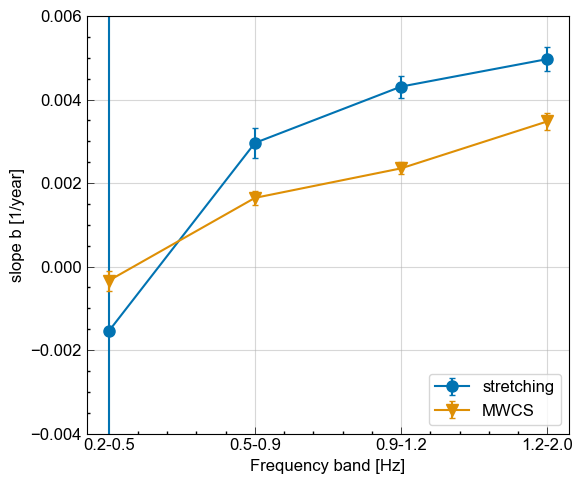

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# sns.lineplot(x="freqkey", y="b_slope", hue="dvvmethod", data=df_freqslope, markers=["o", "v"], style="dvvmethod", palette="colorblind", ms=10)
df_s=df_freqslope[df_freqslope["dvvmethod"]=="stretching"]
df_m=df_freqslope[df_freqslope["dvvmethod"]=="mwcs"]

ax.errorbar(df_s["freqkey"], df_s["b_slope"], yerr=df_s["b_err"], color=cpalette_freq[0], capsize=2, marker="o", ms=8, label="stretching")
ax.errorbar(df_m["freqkey"], df_m["b_slope"], yerr=df_m["b_err"], color=cpalette_freq[1], capsize=2, marker="v", ms=8, label="MWCS")

ax.set_xlabel("Frequency band [Hz]")
ax.set_ylabel("slope b [1/year]")
ax.set_ylim([-0.004, 0.006])
ax.grid(True, alpha=0.5)
ax.legend()

plt.tight_layout()

foname = (output_imgdir+f"/compare_slope_withdifferentfreq.png")
plt.savefig(foname, dpi=150)


## Bar plot of the count of data with different frequency bands

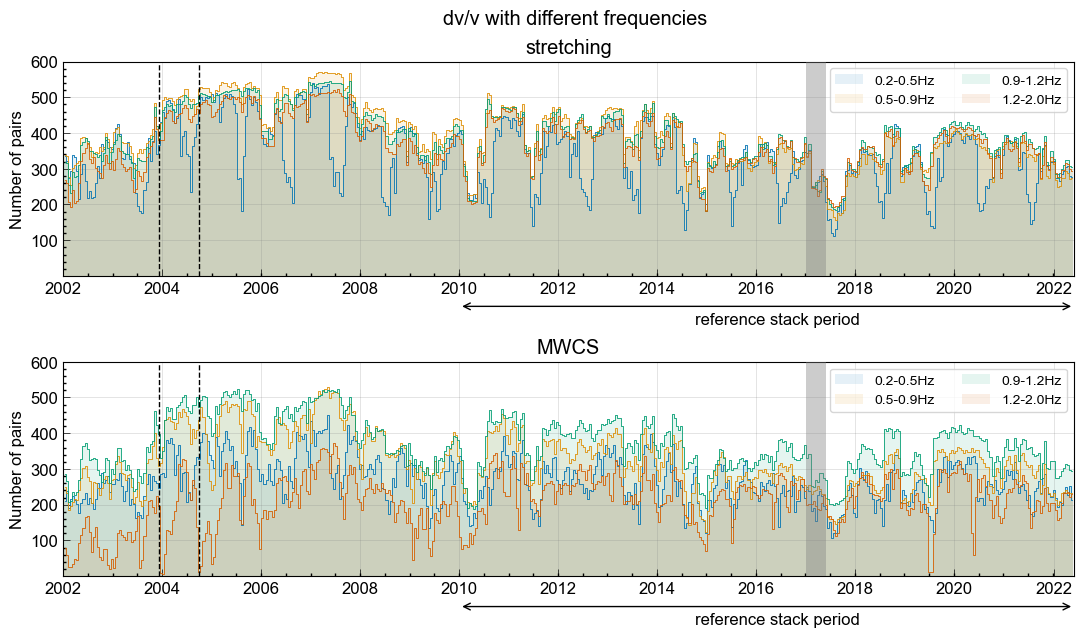

In [47]:
fig, axs = plt.subplots(2, 1, figsize=(11, 6.5), sharex=False, gridspec_kw={'height_ratios': [1, 1]})

for i, freqkey in enumerate(freqkeys):
    #---Extract the date with the freqkey---#
    df_dvvfreq_stretching = df_stretching.loc[:, "dvv"].loc[:, df_stretching.loc[:, "dvv"].columns.get_level_values("freqband")==freqkey]
    df_ccfreq_stretching = df_stretching.loc[:, "cc_dvv"].loc[:, df_stretching.loc[:, "cc_dvv"].columns.get_level_values("freqband")==freqkey]
    df_errfreq_stretching = df_stretching.loc[:, "err"].loc[:, df_stretching.loc[:, "err"].columns.get_level_values("freqband")==freqkey]

    df_dvvfreq_mwcs = df_mwcs.loc[:, "dvv"].loc[:, df_mwcs.loc[:, "dvv"].columns.get_level_values("freqband")==freqkey]
    df_ccfreq_mwcs = df_mwcs.loc[:, "cc_dvv"].loc[:, df_mwcs.loc[:, "cc_dvv"].columns.get_level_values("freqband")==freqkey]
    df_errfreq_mwcs = df_mwcs.loc[:, "err"].loc[:, df_mwcs.loc[:, "err"].columns.get_level_values("freqband")==freqkey]

    #---Threshold out the dvv with cc and err for the cases with stretching and mwcs, respectively---#
    df_dvvfreq_stretching.mask(df_ccfreq_stretching < cc_threshold, inplace=True)
    df_dvvfreq_mwcs.mask(df_errfreq_mwcs > err_mwcs_eps, inplace=True)


    #---Compute stats---#
    df_dvvfreq_stretching_stats = df_dvvfreq_stretching.quantile([0.25, 0.5, 0.75], axis=1).T # 1st, 2nd, and 3rd quartiles
    df_dvvfreq_stretching_stats.loc[:, "mean"] = df_dvvfreq_stretching.mean(skipna=True, axis=1).T #mean
    df_dvvfreq_stretching_stats.loc[:, "std"] = df_dvvfreq_stretching.std(skipna=True, axis=1).T #std
    df_dvvfreq_stretching_stats.loc[:, "count"] = df_dvvfreq_stretching.count(axis=1).T #number of data with each time window

    df_dvvfreq_mwcs_stats = df_dvvfreq_mwcs.quantile([0.25, 0.5, 0.75], axis=1).T # 1st, 2nd, and 3rd quartiles
    df_dvvfreq_mwcs_stats.loc[:, "mean"] = df_dvvfreq_mwcs.mean(skipna=True, axis=1).T #mean
    df_dvvfreq_mwcs_stats.loc[:, "std"] = df_dvvfreq_mwcs.std(skipna=True, axis=1).T #std
    df_dvvfreq_mwcs_stats.loc[:, "count"] = df_dvvfreq_mwcs.count(axis=1).T #number of data with each time window

    # Plot bar chart of count of station pairs    
    axs[0].bar(uniform_tvec, df_dvvfreq_stretching_stats["count"], width=15, color=cpalette_freq[i], alpha=0.1, label=freqlabels[i])
    axs[0].step(uniform_tvec, df_dvvfreq_stretching_stats["count"], color=cpalette_freq[i],where="mid",linewidth=0.6)
    axs[0].set_title("stretching")

    axs[1].bar(uniform_tvec, df_dvvfreq_mwcs_stats["count"], width=15, color=cpalette_freq[i], alpha=0.1, label=freqlabels[i])
    axs[1].step(uniform_tvec, df_dvvfreq_mwcs_stats["count"], color=cpalette_freq[i], where="mid",linewidth=0.6)
    axs[1].set_title("MWCS")

xfmt = dates.DateFormatter('%Y')
for i in range(2):
    axs[i].set_ylim(0, 600)
    axs[i].set_yticks(np.arange(100, 610, 100))
    axs[i].set_ylabel("Number of pairs")
    axs[i].set_xlim(starttime, endtime)
    axs[i].grid(True, axis="both", lw=0.5, c="gray", alpha=0.3, zorder=-1)
#     plt.setp(axs[i].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    for vline in vlines:
        axs[i].axvline(vline,
                    color='k',
                    linewidth=1.0,
                    linestyle='--',
                    zorder=2)
    axs[i].xaxis.set_major_formatter(xfmt)   
    # period of unstable dv/v
    vlines_unstable = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 6, 1)]
    axs[i].fill_betweenx([0, 600], vlines_unstable[0], vlines_unstable[1], fc="gray", alpha=0.4, ls="-", zorder=10)

    # annotate reference period
    refy = -85
    axs[i].annotate('', xy=(refstarttime, refy), xytext=(refendtime, refy), arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
    axs[i].text(datetime.datetime(2016,6,1), -100, "reference stack period", ha="center", va='top')
    axs[i].legend(loc=1, labelcolor="k", ncol=2, fontsize=10)

    
plt.tight_layout()
fig.suptitle(f'dv/v with different frequencies', x=0.53)
fig.tight_layout(rect=[0,0,1,1.02])
plt.subplots_adjust(hspace=0.4)
fig.align_ylabels()

foname = (output_imgdir+f"/dvv_differentfrequencies_{freqkey}Hz_numberofpairs.png")
plt.savefig(foname, dpi=150)

# Compare the dv/v after channel weighting

Channel weighting is done in `modelfit_01_preprocess_dvv_v01.ipynb`. We read the output in .h5 and compare with the data before channel weighting.

In [48]:
#dvv before channel weighting
freqkey='0.9-1.2'

df_dvvfreq_stretching = df_stretching.loc[:, "dvv"].loc[:, df_stretching.loc[:, "dvv"].columns.get_level_values("freqband")==freqkey]
df_ccfreq_stretching = df_stretching.loc[:, "cc_dvv"].loc[:, df_stretching.loc[:, "cc_dvv"].columns.get_level_values("freqband")==freqkey]
df_errfreq_stretching = df_stretching.loc[:, "err"].loc[:, df_stretching.loc[:, "err"].columns.get_level_values("freqband")==freqkey]

df_dvvfreq_mwcs = df_mwcs.loc[:, "dvv"].loc[:, df_mwcs.loc[:, "dvv"].columns.get_level_values("freqband")==freqkey]
df_ccfreq_mwcs = df_mwcs.loc[:, "cc_dvv"].loc[:, df_mwcs.loc[:, "cc_dvv"].columns.get_level_values("freqband")==freqkey]
df_errfreq_mwcs = df_mwcs.loc[:, "err"].loc[:, df_mwcs.loc[:, "err"].columns.get_level_values("freqband")==freqkey]

#---Threshold out the dvv with cc and err for the cases with stretching and mwcs, respectively---#
df_dvvfreq_stretching.mask(df_ccfreq_stretching < cc_threshold, inplace=True)
df_dvvfreq_mwcs.mask(df_errfreq_mwcs > err_mwcs_eps, inplace=True)


#---Compute stats---#
df_dvvfreq_stretching_stats = df_dvvfreq_stretching.quantile([0.25, 0.5, 0.75], axis=1).T # 1st, 2nd, and 3rd quartiles
df_dvvfreq_stretching_stats.loc[:, "mean"] = df_dvvfreq_stretching.mean(skipna=True, axis=1).T #mean
df_dvvfreq_stretching_stats.loc[:, "std"] = df_dvvfreq_stretching.std(skipna=True, axis=1).T #std
df_dvvfreq_stretching_stats.loc[:, "count"] = df_dvvfreq_stretching.count(axis=1).T #number of data with each time window

df_dvvfreq_mwcs_stats = df_dvvfreq_mwcs.quantile([0.25, 0.5, 0.75], axis=1).T # 1st, 2nd, and 3rd quartiles
df_dvvfreq_mwcs_stats.loc[:, "mean"] = df_dvvfreq_mwcs.mean(skipna=True, axis=1).T #mean
df_dvvfreq_mwcs_stats.loc[:, "std"] = df_dvvfreq_mwcs.std(skipna=True, axis=1).T #std
df_dvvfreq_mwcs_stats.loc[:, "count"] = df_dvvfreq_mwcs.count(axis=1).T #number of data with each time window

In [49]:
# dvv after channel weighting
root_h5 = "../processed_data/"
data_contents_min = 0.0 # threshold of data contents

h5_stats_list = [root_h5+f"/dvvtraces_chanweighted_monitoring_stats_uwbackup_2010-2022_stretching.csv_{freqkey}.h5",
                  root_h5+f"/dvvtraces_chanweighted_monitoring_stats_uwbackup_2010-2022_mwcs.csv_{freqkey}.h5"]

In [50]:
fi = h5py.File(h5_stats_list[0], "r")
uniform_tvec_h5 = np.array(fi['uniform_tvec'])
#NOTE: the last date (2022, 5, 31) is removed in the uniform_tvec
# because it is skipped when applying pivot for the rearrangement of csv data during the conversion as no data exists among station pairs.
assert (uniform_tvec == [datetime.datetime.fromtimestamp(x) for x in uniform_tvec_h5][:-1])
fi.close()

In [51]:
# initialize empty dataframe
df_h5_dvv_all = pd.DataFrame()
df_h5_cc_all = pd.DataFrame()
df_h5_err_all = pd.DataFrame()

for idvv, dvvmethod in enumerate(["stretching", "mwcs"]):
    fi = h5py.File(h5_stats_list[idvv], "r")
    stationpairs = list(fi['dvv'].keys())
    
    for sta in stationpairs:
    #     print(sta)
        datacontents = float(np.array(fi['dvv/{}/datacontents'.format(sta)]))
        fitcontents = float(np.array(fi['dvv/{}/fitcontents'.format(sta)]))
        t_unix = np.array(fi['dvv/{}/t_unix'.format(sta)])
        dvv_tmp = np.array(fi['dvv/{}/dvv'.format(sta)])
        cc_tmp = np.array(fi['dvv/{}/cc'.format(sta)])
        err_tmp = np.array(fi['dvv/{}/err'.format(sta)])

        # threshold: check datacontents
        if (datacontents > data_contents_min):
            # store dvv
            col = pd.MultiIndex.from_tuples([(dvvmethod, sta)], names=["dvvmethod", "stationpair"])

            # store dvv
            df_dvv = pd.DataFrame(dvv_tmp, columns=col, index=t_unix)
            # left outer join
            if df_h5_dvv_all.empty:
                df_h5_dvv_all = df_dvv
            else:
                df_h5_dvv_all = pd.merge(df_h5_dvv_all, df_dvv, how='outer', left_index=True, right_index=True)

            # store cc
            df_cc = pd.DataFrame(cc_tmp, columns=col, index=t_unix)
            # left outer join
            if df_h5_cc_all.empty:
                df_h5_cc_all = df_cc
            else:
                df_h5_cc_all = pd.merge(df_h5_cc_all, df_cc, how='outer', left_index=True, right_index=True)

            # store err
            df_err = pd.DataFrame(err_tmp, columns=col, index=t_unix)
            if df_h5_err_all.empty:
                df_h5_err_all = df_err
            else:
                df_h5_err_all = pd.merge(df_h5_err_all, df_err, how='outer', left_index=True, right_index=True)

                
        else:
            #data contents is not enough. skipping
            continue

In [52]:
#---Threshold out the dvv with cc and err for the cases with stretching and mwcs, respectively---#
df_h5_dvv_stretching = df_h5_dvv_all.loc[:, "stretching"].copy()
df_h5_dvv_mwcs = df_h5_dvv_all.loc[:, "mwcs"].copy()

df_h5_cc_stretching = df_h5_cc_all.loc[:, "stretching"]
df_h5_err_mwcs = df_h5_err_all.loc[:, "mwcs"]

df_h5_dvv_stretching.mask(df_h5_cc_stretching < cc_threshold, inplace=True) # cc of stretching after channel weight is evaluated with error propagation
df_h5_dvv_mwcs.mask(df_h5_err_mwcs > err_mwcs_eps, inplace=True) # error of mwcs after channel weight is the RMS of the summed channel pairs


In [53]:
#### ---Compute stats---#
df_dvvfreq_stretching_stats_h5 = df_h5_dvv_stretching.quantile([0.25, 0.5, 0.75], axis=1).T # 1st, 2nd, and 3rd quartiles
df_dvvfreq_stretching_stats_h5.loc[:, "mean"] = df_h5_dvv_stretching.mean(skipna=True, axis=1).T #mean
df_dvvfreq_stretching_stats_h5.loc[:, "std"] = df_h5_dvv_stretching.std(skipna=True, axis=1).T #std
df_dvvfreq_stretching_stats_h5.loc[:, "count"] = df_h5_dvv_stretching.count(axis=1).T #number of data with each time window

df_dvvfreq_mwcs_stats_h5 = df_h5_dvv_mwcs.quantile([0.25, 0.5, 0.75], axis=1).T # 1st, 2nd, and 3rd quartiles
df_dvvfreq_mwcs_stats_h5.loc[:, "mean"] = df_h5_dvv_mwcs.mean(skipna=True, axis=1).T #mean
df_dvvfreq_mwcs_stats_h5.loc[:, "std"] = df_h5_dvv_mwcs.std(skipna=True, axis=1).T #std
df_dvvfreq_mwcs_stats_h5.loc[:, "count"] = df_h5_dvv_mwcs.count(axis=1).T #number of data with each time window

## Plot dvv comparison with the channel weighting

In [54]:
cpalette_h5=np.array(sns.color_palette("colorblind"))[:]
cpalette_h5[7, :] = [0.5, 0.5, 0.5]

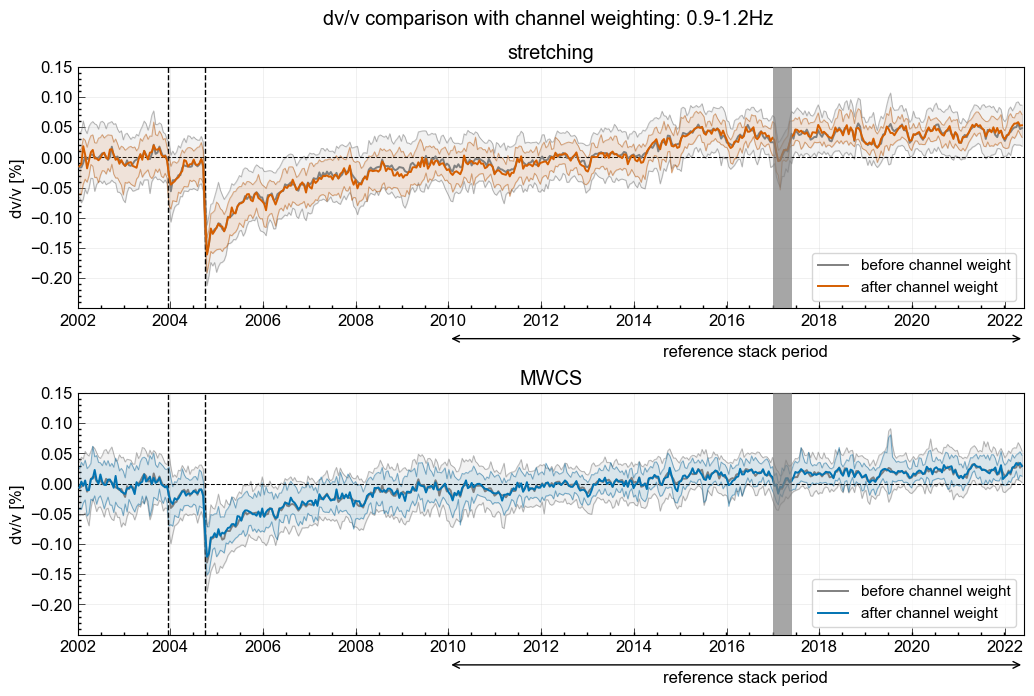

In [55]:
fig, axs = plt.subplots(2, 1, figsize=(10.5, 7.1), sharex=False, gridspec_kw={'height_ratios': [1, 1]}) #(10.5, 9.1)
dvvdata_IsOffsetRemoval=True

#---plot dvv before channel weighting---#
if dvvdata_IsOffsetRemoval:
    offset_ind = np.where(np.array(uniform_tvec) < tSS)
    offset_data1 = np.nanmean(df_dvvfreq_stretching_stats[0.5].values[offset_ind]) # offset is evaluated with the mean of median dvv
    offset_data2 = np.nanmean(df_dvvfreq_mwcs_stats[0.5].values[offset_ind]) # offset is evaluated with the mean of median dvv
else:
    offset_data1 = 0
    offset_data2 = 0

# stretching
ic = 7
axs[0].plot(uniform_tvec, df_dvvfreq_stretching_stats[0.5].values-offset_data1, "-", c=cpalette_h5[ic], label="before channel weight", zorder=6, lw=1.4) # median
ybot1 =  df_dvvfreq_stretching_stats[0.25].values-offset_data1 #  1st quartile
ytop1 =  df_dvvfreq_stretching_stats[0.75].values-offset_data1 #  3rd quartile
axs[0].fill_between(uniform_tvec, ybot1, ytop1, color=cpalette_h5[ic], alpha=0.1, label="", ec="k", lw=0.5, zorder=5)
axs[0].plot(uniform_tvec, ybot1, c=cpalette_h5[ic], alpha=0.5, lw=0.7, ls="-")
axs[0].plot(uniform_tvec, ytop1, c=cpalette_h5[ic], alpha=0.5, lw=0.7, ls="-")
axs[0].legend(loc=4, labelcolor="k", fontsize=11)

# mwcs
ic = 7
axs[1].plot(uniform_tvec, df_dvvfreq_mwcs_stats[0.5].values-offset_data2, "-", c=cpalette_h5[ic], label="before channel weight", zorder=6, lw=1.4) # median
ybot2 =  df_dvvfreq_mwcs_stats[0.25].values-offset_data2 #  1st quartile
ytop2 =  df_dvvfreq_mwcs_stats[0.75].values-offset_data2 #  3rd quartile
axs[1].fill_between(uniform_tvec, ybot2, ytop2, color=cpalette_h5[ic], alpha=0.1, label="", ec="k", lw=0.5, zorder=5)
axs[1].plot(uniform_tvec, ybot2, c=cpalette_h5[ic], alpha=0.5, lw=0.7, ls="-")
axs[1].plot(uniform_tvec, ytop2, c=cpalette_h5[ic], alpha=0.5, lw=0.7, ls="-")
axs[1].legend(loc=4, labelcolor="k", fontsize=11)

axs[0].set_title("stretching")
axs[1].set_title("MWCS")

#---plot dvv after channel weighting---#
uniform_tvec_h5 = [datetime.datetime.fromtimestamp(x) for x in df_dvvfreq_stretching_stats_h5.index]

if dvvdata_IsOffsetRemoval:
    offset_ind = np.where(np.array(uniform_tvec) < tSS)
    offset_data1 = np.nanmean(df_dvvfreq_stretching_stats_h5[0.5].values[offset_ind]) # offset is evaluated with the mean of median dvv
    offset_data2 = np.nanmean(df_dvvfreq_mwcs_stats_h5[0.5].values[offset_ind]) # offset is evaluated with the mean of median dvv
else:
    offset_data1 = 0
    offset_data2 = 0

# stretching
ic = 3
axs[0].plot(uniform_tvec_h5, df_dvvfreq_stretching_stats_h5[0.5].values-offset_data1, "-", c=cpalette_h5[ic], label="after channel weight", zorder=6, lw=1.4) # median
ybot1 =  df_dvvfreq_stretching_stats_h5[0.25].values-offset_data1 #  1st quartile
ytop1 =  df_dvvfreq_stretching_stats_h5[0.75].values-offset_data1 #  3rd quartile
axs[0].fill_between(uniform_tvec_h5, ybot1, ytop1, color=cpalette_h5[ic], alpha=0.1, label="", ec="k", lw=0.5, zorder=5)
axs[0].plot(uniform_tvec_h5, ybot1, c=cpalette_h5[ic], alpha=0.5, lw=0.7, ls="-")
axs[0].plot(uniform_tvec_h5, ytop1, c=cpalette_h5[ic], alpha=0.5, lw=0.7, ls="-")
axs[0].legend(loc=4, labelcolor="k", fontsize=11)

# mwcs
ic = 0
axs[1].plot(uniform_tvec_h5, df_dvvfreq_mwcs_stats_h5[0.5].values-offset_data2, "-", c=cpalette_h5[ic], label="after channel weight", zorder=6, lw=1.4) # median
ybot2 =  df_dvvfreq_mwcs_stats_h5[0.25].values-offset_data2 #  1st quartile
ytop2 =  df_dvvfreq_mwcs_stats_h5[0.75].values-offset_data2 #  3rd quartile
axs[1].fill_between(uniform_tvec_h5, ybot2, ytop2, color=cpalette_h5[ic], alpha=0.1, label="", ec="k", lw=0.5, zorder=5)
axs[1].plot(uniform_tvec_h5, ybot2, c=cpalette_h5[ic], alpha=0.5, lw=0.7, ls="-")
axs[1].plot(uniform_tvec_h5, ytop2, c=cpalette_h5[ic], alpha=0.5, lw=0.7, ls="-")
axs[1].legend(loc=4, labelcolor="k", fontsize=11)

axs[0].set_title("stretching")
axs[1].set_title("MWCS")

xfmt = dates.DateFormatter('%Y')
for i in range(2):
    axs[i].set_ylim(-0.25, 0.15)
    axs[i].set_yticks(np.linspace(-0.20, 0.15, 8))
    axs[i].set_ylabel("dv/v [%]")
    axs[i].set_xlim(starttime, endtime)
    axs[i].grid(True, axis="both", lw=0.5, c=[0.8, 0.8, 0.8], alpha=0.4, zorder=-20)
    axs[i].axhline(0, c="k", lw=0.75, ls="--")

#     plt.setp(axs[i].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    # plot the date of San Simeon and Parkfield eq.
    for vline in vlines:
        axs[i].axvline(vline,
                    color='k',
                    linewidth=1.0,
                    linestyle='--',
                    zorder=2)
        
    # period of unstable dv/v
    vlines_unstable = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 6, 1)]
    axs[i].fill_betweenx([-0.3, 0.3], vlines_unstable[0], vlines_unstable[1], fc="gray", alpha=0.7, ls="-", zorder=10)

    # annotate reference period
    refy = -0.3
    axs[i].annotate('', xy=(refstarttime, refy), xytext=(refendtime, refy), arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
    axs[i].text(datetime.datetime(2016,6,1), -0.31, "reference stack period", ha="center", va='top')
    # axs[1].plot([refstarttime, refendtime], [-0.3, -0.3], clip_on=False,)

plt.tight_layout()

fig.suptitle(f'dv/v comparison with channel weighting: {freqkey}Hz', x=0.53)
fig.tight_layout(rect=[0,0,1,1.01])
plt.subplots_adjust(hspace=0.35)
fig.align_ylabels()

foname = (output_imgdir+f"/dvv_comparison-with-channelweighting_{freqkey}Hz.png")
plt.savefig(foname, dpi=150)

## Bar plot of the count of data for the comparison with channel weighted dv/v

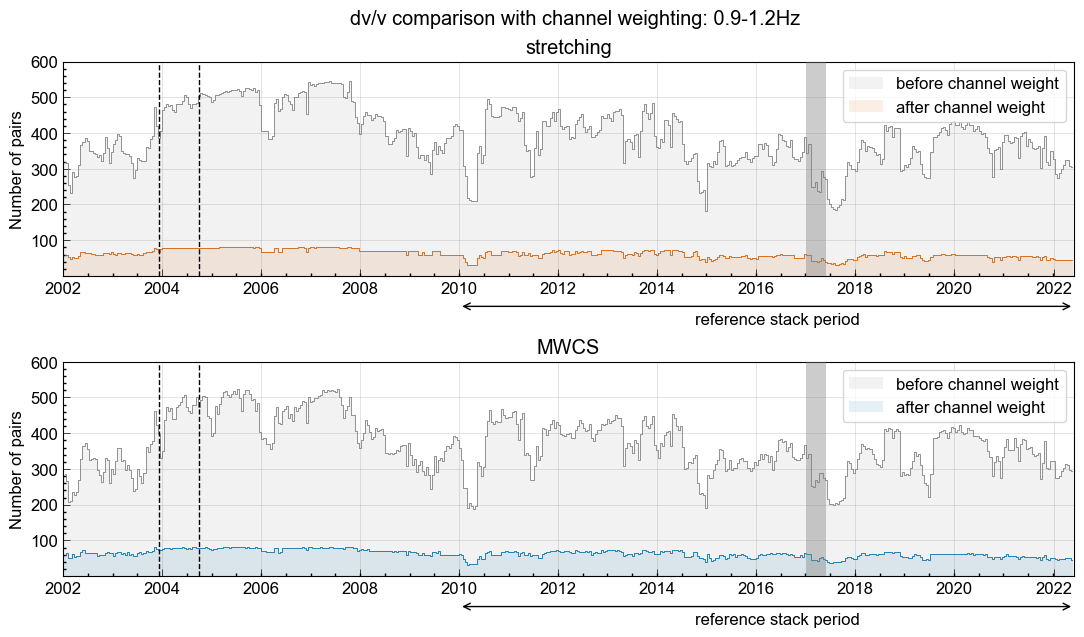

In [56]:
fig, axs = plt.subplots(2, 1, figsize=(11, 6.5), sharex=False, gridspec_kw={'height_ratios': [1, 1]})

#---plot dvv before channel weighting---#
ic=7
axs[0].bar(uniform_tvec, df_dvvfreq_stretching_stats["count"], width=15, color=cpalette_h5[ic], alpha=0.1,label="before channel weight")
axs[0].step(uniform_tvec, df_dvvfreq_stretching_stats["count"], color=cpalette_h5[ic],where="mid",linewidth=0.6)
axs[0].set_title("stretching")

axs[1].bar(uniform_tvec, df_dvvfreq_mwcs_stats["count"], width=15, color=cpalette_h5[ic], alpha=0.1, label="before channel weight")
axs[1].step(uniform_tvec, df_dvvfreq_mwcs_stats["count"], color=cpalette_h5[ic], where="mid",linewidth=0.6)
axs[1].set_title("MWCS")

#---plot dvv after channel weighting---#
ic = 3
axs[0].bar(uniform_tvec, df_dvvfreq_stretching_stats_h5["count"], width=15, color=cpalette_h5[ic], alpha=0.1,label="after channel weight")
axs[0].step(uniform_tvec, df_dvvfreq_stretching_stats_h5["count"], color=cpalette_h5[ic],where="mid",linewidth=0.6)
ic = 0
axs[1].bar(uniform_tvec, df_dvvfreq_mwcs_stats_h5["count"], width=15, color=cpalette_h5[ic], alpha=0.1, label="after channel weight")
axs[1].step(uniform_tvec, df_dvvfreq_mwcs_stats_h5["count"], color=cpalette_h5[ic], where="mid",linewidth=0.6)

xfmt = dates.DateFormatter('%Y')
for i in range(2):
    axs[i].set_ylim(0, 600)
    axs[i].set_yticks(np.arange(100, 610, 100))
    axs[i].set_ylabel("Number of pairs")
    axs[i].set_xlim(starttime, endtime)
    axs[i].grid(True, axis="both", lw=0.5, c="gray", alpha=0.3, zorder=-1)
#     plt.setp(axs[i].get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    for vline in vlines:
        axs[i].axvline(vline,
                    color='k',
                    linewidth=1.0,
                    linestyle='--',
                    zorder=2)
    axs[i].xaxis.set_major_formatter(xfmt)   
    # period of unstable dv/v
    vlines_unstable = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 6, 1)]
    axs[i].fill_betweenx([0, 600], vlines_unstable[0], vlines_unstable[1], fc="gray", alpha=0.4, ls="-", zorder=10)

    # annotate reference period
    refy = -85
    axs[i].annotate('', xy=(refstarttime, refy), xytext=(refendtime, refy), arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
    axs[i].text(datetime.datetime(2016,6,1), -100, "reference stack period", ha="center", va='top')
    axs[i].legend(loc=1, labelcolor="k", ncol=1, fontsize=12)

    
plt.tight_layout()
fig.suptitle(f'dv/v comparison with channel weighting: {freqkey}Hz', x=0.53)
fig.tight_layout(rect=[0,0,1,1.02])
plt.subplots_adjust(hspace=0.4)
fig.align_ylabels()

foname = (output_imgdir+f"/dvv_comparison-with-channelweighting_{freqkey}Hz_numofpairs.png")
plt.savefig(foname, dpi=150)

**NOTE:** The number of channel weighted data is small because we unify the 3x3 channel correlations. It rather helps the stability in the number of pairs over the time to improve the continuity of the dv/v time history.

# Conclusion

In this notebook, we plotted the dvv time history for the cases with all components, different station-channel pairs and different frequencies. We also checked that the time history does not vary so much even after channel weighting.
We then move to the model fitting with MCMC to quantify the model parameters associated with precipitation, temperature, coseismic drop and the linear slope in the time history.